# 08. 고급 회귀분석 방법

In [1]:
%matplotlib inline

## 최소 각도 회귀 LARS
전진 선택 알고리즘과 전진적 스테이지와이즈 회귀 알고리즘을 발전시킨 기법

.

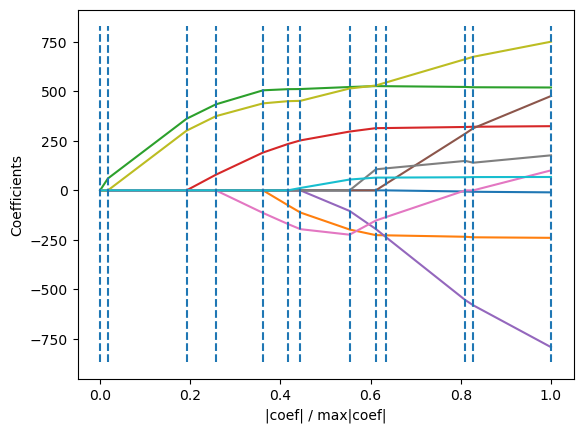

In [11]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, linear_model

X, y = datasets.load_diabetes(return_X_y=True)

_, _, coefs = linear_model.lars_path(X, y, method="lasso", verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle="dashed")
plt.xlabel("|coef| / max|coef|")
plt.ylabel("Coefficients")
plt.axis("tight")
plt.show()

색깔선 -> 계수의 값 / 점선 -> 단계

In [12]:
#LARS 계수(가중치) 출력
regr = linear_model.Lars()

regr.fit(X, y)

print("Coefficients are:", regr.coef_)
print("See also the ending points of the previous graph")

Coefficients are: [ -10.0098663  -239.81564367  519.84592005  324.3846455  -792.17563855
  476.73902101  101.04326794  177.06323767  751.27369956   67.62669218]
See also the ending points of the previous graph


In [13]:
print("R2 score is", regr.score(X,y))

R2 score is 0.5177484222203498


## 베이지안 회귀
선형회귀와 유사하지만 값을 예측하는 대신 확률 분포를 예측

In [14]:
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=10, n_features=1, n_informative=1, noise=3, random_state=1)

In [16]:
#선형모델 적합
regr = linear_model.LinearRegression()
regr.fit(X, y)

#x값이 훈련 값의 최대치의 두배인 지점의 값을 예측
test_x = 2*np.max(X)
pred_test_x = regr.predict(test_x.reshape(-1, 1))
pred_test_x

array([10.79983753])

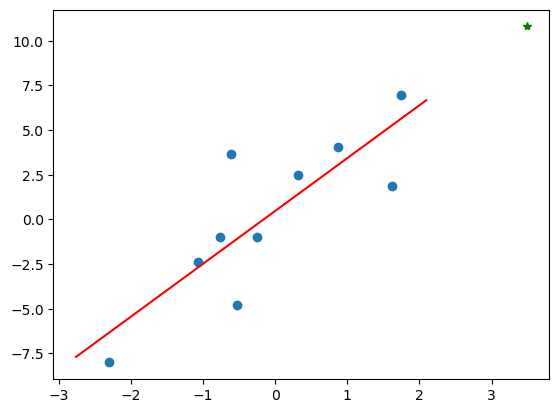

In [17]:
#훈련 지점, 적합 선 및 예측된 테스트 지점 시각화
plt.scatter(X, y)
x_bounds = np.array([1.2*np.min(X), 1.2*np.max(X)]).reshape(-1, 1)
plt.plot(x_bounds, regr.predict(x_bounds) , 'r-')
plt.plot(test_x, pred_test_x, 'g*')
plt.show()

In [22]:
regr = linear_model.BayesianRidge()
regr.fit(X, y)

BayesianRidge()

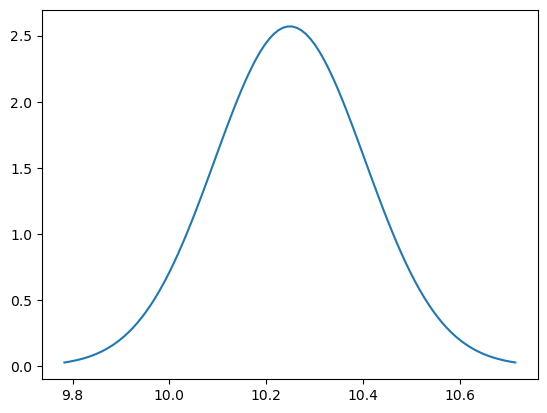

In [29]:
from scipy.stats import norm

mean = regr.predict(test_x.reshape(-1, 1))
stddev = regr.alpha_
plt_x = np.linspace(mean-3*stddev, mean+3*stddev,100)

pdf_values = norm.pdf(plt_x, mean, stddev)

plt.plot(plt_x, pdf_values)
plt.show()
# scipy.stats.norm.pdf() 함수를 사용하여 확률 밀도 함수 계산

In [30]:
regr.alpha_

0.1551883088373445

## 힌지 손실이 있는 SGD(확률적 기울기 하강) 분류
힌지 손실(Hinge Loss)은 주로 서포트 벡터 머신(Support Vector Machine, SVM)과 같은 이진 분류 모델에서 사용되는 손실 함수. 
힌지 손실은 예측값과 실제 레이블 사이의 차이를 측정하는 데 사용되며, 이 값을 최소화하여 모델을 학습함.

힌지hinge 손실 공식

Loss(x) = max(0,1−l*w*x)
w - Classifier의 가중치 집합

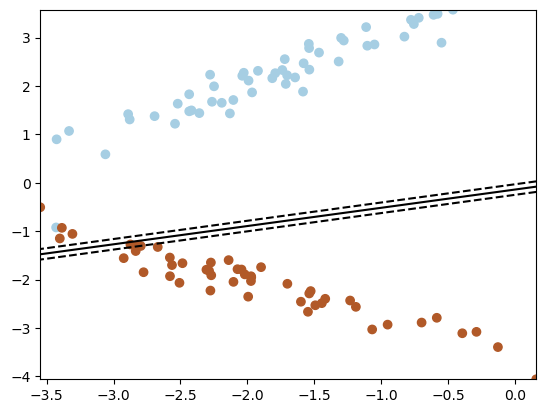

In [36]:
from sklearn.datasets import make_classification
from sklearn.linear_model import SGDClassifier

# we create 50 separable points 50개의 분리 가능한 점 생성
X, y = make_classification(n_samples=100, n_features=2, 
                           n_informative=2, n_redundant=0,
                           n_clusters_per_class=1, class_sep=2, 
                           random_state=101)

# fit the model
clf = SGDClassifier(loss="hinge", max_iter=500, random_state=101, 
                    alpha=0.001)
clf.fit(X, y)

# plot the line, the points, and the nearest vectors to the plane
xx = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 10)
yy = np.linspace(np.min(X[:,1]), np.max(X[:,1]), 10)

X1, X2 = np.meshgrid(xx, yy)
Z = np.empty(X1.shape)
for (i, j), val in np.ndenumerate(X1):
    x1 = val
    x2 = X2[i, j]
    p = clf.decision_function([[x1, x2]])
    Z[i, j] = p[0]
levels = [-1.0, 0.0, 1.0]
linestyles = ['dashed', 'solid', 'dashed']
plt.contour(X1, X2, Z, levels, colors='k', linestyles=linestyles)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)

plt.show()

점선에 있는 점은 서포트 벡터, 결정 경계는 서포트 벡터에서 양쪽으로 같은 거리를 갖는 중간 선이다.

### 로지스틱 회귀와 비교
로지스틱 회귀 학습은 훈련 집합의 모든 입력 점을 사용하고 확률을 아웃풋으로 산출
/ 힌지 손실이 있는 SGD는 레이블을 직접 생성하고, 모델을 향상시키기 위해 경계의 있는 점만을 사용

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X, y = make_classification(n_samples=10000, n_features=20, 
                           n_informative=5, n_redundant=5,
                           n_clusters_per_class=2, class_sep=1,
                           random_state=101)


X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=101)

#힌지 손실 함수를 가지고 있는 SGD Classifier로 훈련
clf_1 = SGDClassifier(loss='hinge', random_state=101)
clf_1.fit(X_train, y_train)
#로지스틱 손실 함수를 가지고 있는 SGD Classifier로 훈련
clf_2 = SGDClassifier(loss='log_loss', random_state=101)
clf_2.fit(X_train, y_train)

#예측의 정확도 비교
print('SVD            : ', accuracy_score(y_test, clf_1.predict(X_test)))
print('Log. Regression: ', accuracy_score(y_test, clf_2.predict(X_test)))

SVD            :  0.86
Log. Regression:  0.8603333333333333


In [40]:
%timeit clf_1.fit(X_train, y_train)

56.5 ms ± 3.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
%timeit clf_2.fit(X_train, y_train)

97 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## SVR Support Vector Regressor
SGD를 사용해 처리 속도 향상 / 아웃풋이 일반적으로 로지스틱회귀보다 정확

In [42]:
#보스턴 데이터셋으로 SVR 작동방법 보고 선형회귀모델과 비교

from sklearn.datasets import fetch_openml

boston = fetch_openml(name='boston')

from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error


X = StandardScaler().fit_transform(boston['data'])
y = boston['target']


X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=101)

regr_1 = SVR(kernel='linear')
regr_1.fit(X_train, y_train)

regr_2 = SGDRegressor(random_state=101)
regr_2.fit(X_train, y_train)

print('SVR            : ', mean_absolute_error(y_test, regr_1.predict(X_test)))
print('Lin. Regression: ', mean_absolute_error(y_test, regr_2.predict(X_test)))

C:\Users\sihyun\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:292: UserWarning: Multiple active versions of the dataset matching the name boston exist. Versions may be fundamentally different, returning version 1.
  warn(
C:\Users\sihyun\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


SVR            :  3.6661222925625228
Lin. Regression:  3.8284539665834014


## 회귀 트리 Decision Trees

In [43]:
from sklearn.tree import DecisionTreeRegressor

regr = DecisionTreeRegressor(random_state=101)
regr.fit(X_train, y_train)

mean_absolute_error(y_test, regr.predict(X_test))

3.3493421052631582

## 배깅과 부스팅
학습자를 결합하는 데 사용되는 기술

### 배깅 Bagging 
1. X 훈련 데이터셋을 구성하는 특성의 80%를 무작위로 선택
2. 약한 학습자는 훈련 데이터셋에서 관찰치의 데이터셋을 대체해 부트스트랩의 선택된 특성에 대해서만 훈련됨

In [45]:
from sklearn.ensemble import BaggingRegressor

bagging = BaggingRegressor(SGDRegressor(), n_jobs=-1,
                          n_estimators=1000, random_state=101, max_features=0.8)

bagging.fit(X_train, y_train)
mean_absolute_error(y_test, bagging.predict(X_test))

3.8028522954341604

#### 결정/회귀트리 사용 배깅

In [46]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=100, 
                             n_jobs=-1, random_state=101)

regr.fit(X_train, y_train)
mean_absolute_error(y_test, regr.predict(X_test))

2.6071052631578944

In [47]:
#모델에서 특성의 중요도를 순위 매기기(어떤 특성이 예측변수의 가장 높은 분산을 생성하는지 감지)

sorted(zip(regr.feature_importances_, boston['feature_names']), key=lambda x: -x[0])
#가장 중요한 특성부터 덜 중요한 특성 순으로 정렬

[(0.5251394785665984, 'LSTAT'),
 (0.27900306354937177, 'RM'),
 (0.054443517360464516, 'DIS'),
 (0.03329193375174695, 'CRIM'),
 (0.02996628136125841, 'NOX'),
 (0.02115216378568037, 'PTRATIO'),
 (0.016097781544041838, 'AGE'),
 (0.014792811839625532, 'TAX'),
 (0.010561142767608146, 'B'),
 (0.007854185838245625, 'INDUS'),
 (0.0054032687523295755, 'RAD'),
 (0.0012874861336010118, 'ZN'),
 (0.001006884749427925, 'CHAS')]

### 부스팅 Boosting
예측 편향을 줄이기 위해 약한 학습자(앙상블)를 결합하는 방법
1. 훈련 집합이 주어지면 이미 적합한 학습자의 Cascade가 예측 생산
2. 실제값과 예측된 값 사이의 오차에 학습률을 곱한 값이 계산됨
3. 새로운 약한 학습자가 해당 오차 집합에 대해 훈련을 받고 이미 훈련된 학습자의 단계식 마지막 단계로 삽입됨

In [48]:
from sklearn.ensemble import AdaBoostRegressor

booster = AdaBoostRegressor(SGDRegressor(), n_estimators=1000, random_state=101, learning_rate=0.01)

booster.fit(X_train, y_train)
mean_absolute_error(y_test, booster.predict(X_test))

4.286677668919136

#### 결정/회귀 트리 사용 부스팅

In [49]:
from sklearn.ensemble import GradientBoostingRegressor

regr = GradientBoostingRegressor(n_estimators=500, 
                                 learning_rate=0.01, 
                                 random_state=101)
regr.fit(X_train, y_train)
mean_absolute_error(y_test, regr.predict(X_test))

2.6046621668252157

In [50]:
#특성 중요도 순위 매기기
sorted(zip(regr.feature_importances_, boston['feature_names']), key=lambda x: -x[0])

[(0.5572443342989275, 'LSTAT'),
 (0.24445904631034404, 'RM'),
 (0.07935646118663138, 'DIS'),
 (0.03726381524294784, 'PTRATIO'),
 (0.035412008346331396, 'NOX'),
 (0.020817026628972547, 'CRIM'),
 (0.0106677042684928, 'TAX'),
 (0.0063911372724677895, 'B'),
 (0.0037906194389681607, 'INDUS'),
 (0.002605029130674535, 'AGE'),
 (0.0008004262803154585, 'RAD'),
 (0.0007986798707423091, 'CHAS'),
 (0.0003937117241843198, 'ZN')]

## LAD(최소 절대 편차)를 이용한 기울기 부스팅 리그레서(GBM, Gradient Boosting Machine)
LAD를 기반으로 하면 손실 함수의 최솟값이 여러 개이기 때문에 불안정, 기울기 부스팅과 같이 사용되면 부스팅이 LAD 회귀 한계를 극복하기 때문에 매우 안정된 리그레서 생성

In [56]:
from sklearn.ensemble import GradientBoostingRegressor
# 'lad' 대신 손실 함수로서 'absolute_error'를 사용하여 대체
regr = GradientBoostingRegressor(loss='absolute_error', n_estimators=500, learning_rate=0.1, random_state=101)

regr.fit(X_train, y_train)
mean_absolute_error(y_test, regr.predict(X_test))

2.67781448806759